# 過去10日間のデータから当日上昇するか否かを予測するモデル

- ロジスティック回帰
- ランダムフォレスト

### 結果
- ロジスティック回帰ではテストデータの予測性能はほぼランダムだった
- ランダムフォレストでも、デフォルトのパラメータではよそく性能はランダムだった
- グリッドサーチをすると、分類器の数を増やしたり木の最大深さを深くするなどパラメータに柔軟性を持たせたら、学習データではほぼ100%になったが、これは単に個々のサンプルにフィットした木を作っているに過ぎないようだ
    - テストデータではほぼランダムだった
- パラメータの柔軟性を低くしたら、訓練データのフィットは60 - 70%ぐらいまで下がり、テストデータの予測性能はやはりランダムだった

### 考察
- このデータではランダム性を排除した価格の値動きの特徴を学習することはできないようだ
- 入力データの選別あるいはまた異なるデータを追加するなどの必要がある
- 出力についても、上昇 or not の２値ではなく、３値とかもう少し細かい分類にする方法もある
- トレンド除去とかも有効かもしれない

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

- E-MiniS&P500の日足データ（TradeStationからエクスポートしたもの）
- 最新の限月価格を基準にして過去の限月価格との差額を単純に過去限月価格に足して限月間のずれを解消したつなぎ足データ
    - 単純な方法でよく用いられるが、過去限月の価格が0以下になることがある
    - 今回のデータでは、Open, High, Low, Closeで0以下の値はない

In [2]:
base_dir = 'data/e-mini-sp500-200530'
df_raw = pd.read_csv(f'{base_dir}/e-mini-sp500-daily.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5729 non-null   object 
 1   Time    5729 non-null   object 
 2   Open    5729 non-null   float64
 3   High    5729 non-null   float64
 4   Low     5729 non-null   float64
 5   Close   5729 non-null   float64
 6   Vol     5729 non-null   int64  
 7   OI      5729 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 358.2+ KB


# ベースデータ作成

- 過去10足分まで見れるデータにする
- 二次的指標の追加
    - イントラバーの値動き
    - 2足間の値の動き
- 月の上旬・中旬・下旬という情報を入れるため最初の月（1997年9月）は中途半端だから除外。
    - 始めの数年間は直近と比べると出来高が非常に小さく流動性が低いが、今は日足での値動きに注目しているため問題ないとみなして、それらのデータは除外しない
- コロナの暴落データ（2020年2月以降）はめったに起こらない事象だからデータから除外。
- 年、月、月の上旬・中旬・下旬、曜日を入れる

In [3]:
# 過去N足分まで見れるデータにする

# 何足分見るか
N_BARS = 10

df = fl.make_nbars(df_raw, N_BARS, cols=['Open', 'High', 'Low', 'Close', 'Vol', 'OI'])
#fl.make_nbars(df_raw[:21], 10)
df.head(3)

,Date,Time,Open10,High10,Low10,Close10,Vol10,OI10,Open9,High9,...,Low1,Close1,Vol1,OI1,Open0,High0,Low0,Close0,Vol0,OI0
0,09/25/1997,17:00,1071.25,1082.25,1062.75,1068.50,11825,2909,1070.50,1089.00,...,1104.5,1106.00,14580.0,6194.0,1106.25,1110.0,1098.00,1099.25,14114.0,6132.0
1,09/26/1997,17:00,1070.50,1089.00,1066.00,1071.25,9759,4059,1086.00,1092.25,...,1098.0,1099.25,14114.0,6132.0,1099.00,1109.0,1099.00,1106.00,12049.0,5666.0
2,09/29/1997,17:00,1086.00,1092.25,1081.50,1083.75,8551,3818,1083.75,1112.50,...,1099.0,1106.00,12049.0,5666.0,1105.75,1117.0,1102.75,1114.50,11104.0,5722.0


In [4]:
# 値動き指標を追加

# イントラバーの値動き
for i in range(N_BARS+1):
    df[f'CODiff{i}'] = df[f'Close{i}'] - df[f'Open{i}'] # 終値 - 始値
    df[f'HLDiff{i}'] = df[f'High{i}'] - df[f'Low{i}'] # 高値 - 安値
    df[f'HCDiff{i}'] = df[f'High{i}'] - df[f'Close{i}'] # 高値 - 終値
    df[f'OLDiff{i}'] = df[f'Open{i}'] - df[f'Low{i}'] # 始値 - 安値
    df[f'CLDiff{i}'] = df[f'Close{i}'] - df[f'Low{i}'] # 終値 - 安値
    
# 2足間の値動き
for i in range(N_BARS):
    df[f'CSlope{i}'] = df[f'Close{i}'] - df[f'Close{i+1}'] # ある日の終値 - 前日の終値
    df[f'OSlope{i}'] = df[f'Open{i}'] - df[f'Open{i+1}'] # ある日の始値 - 前日の始値
    df[f'LSlope{i}'] = df[f'Low{i}'] - df[f'Low{i+1}'] # ある日の安値 - 前日の安値
    df[f'HSlope{i}'] = df[f'High{i}'] - df[f'High{i+1}'] # ある日の高値 - 前日の高値
    df[f'VSlope{i}'] = df[f'Vol{i}'] - df[f'Vol{i+1}'] # ある日の出来高 - 前日の出来高
    df[f'OISlope{i}'] = df[f'OI{i}'] - df[f'OI{i+1}'] # ある日の建玉数 - 前日の建玉数
    df[f'HCSlope{i}'] = df[f'High{i}'] - df[f'Close{i+1}'] # ある日の高値 - 前日の終値
    df[f'CLSlope{i}'] = df[f'Close{i+1}'] - df[f'Low{i}'] # ある日の前日の終値 - ある日の安値

In [5]:
# DateをDatetime型にする
df['Date'] = df['Date'].map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y').date())

# 始まりの年月と終わりの年月（終わりは含まない）
s_year, s_month = 1997, 10
e_year, e_month = 2020, 2

df = df[(df['Date'] >= dt.date(s_year,s_month,1)) & (df['Date'] < dt.date(e_year,e_month,1))]
df = df.reset_index(drop=True)
df.info()
print('\n始めのデータ\n', df[:1])
print('\n終わりのデータ\n', df[-1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5633 entries, 0 to 5632
Columns: 203 entries, Date to CLSlope9
dtypes: float64(199), int64(2), object(2)
memory usage: 8.7+ MB

始めのデータ
          Date   Time  Open10  High10   Low10  Close10  Vol10  OI10    Open9  \
0  1997-10-01  17:00  1108.5  1115.0  1104.0   1108.5  10849  5516  1108.25   

    High9  ...  HCSlope8  CLSlope8  CSlope9  OSlope9  LSlope9  HSlope9  \
0  1123.0  ...      5.25       5.0      2.0    -0.25     3.25      8.0   

   VSlope9  OISlope9  HCSlope9  CLSlope9  
0    739.0     606.0      14.5      1.25  

[1 rows x 203 columns]

終わりのデータ
             Date   Time  Open10   High10    Low10  Close10    Vol10     OI10  \
5632  2020-01-31  17:00  3283.0  3306.75  3282.75  3305.25  1335246  2716639   

       Open9   High9  ...  HCSlope8  CLSlope8  CSlope9  OSlope9  LSlope9  \
5632  3305.5  3319.0  ...      4.75     17.75      8.5     22.5     22.0   

      HSlope9  VSlope9  OISlope9  HCSlope9  CLSlope9  
5632    12.25 -22

In [6]:
# 年列を入れる
df['year'] = df['Date'].map(lambda date: date.year)
# 月列を入れる
df['month'] = df['Date'].map(lambda date: date.month)
# 曜日列を入れる
day_type = CategoricalDtype(categories=["Mon", "Tue", "Wed", "Thu", "Fri"], ordered=True)
df['day'] = df['Date'].map(lambda d: d.strftime('%a')).astype(day_type)

In [7]:
# 月の上旬・中旬・下旬の列を入れる
# 月初めから7日間を上旬、次の7日間を中旬、それ以降を下旬とする
tdm_type = CategoricalDtype(categories=['Early', 'Mid', 'Late'])
df['tdm'] = 'Early'
y_m = dt.date(s_year, s_month, 1)
while True:
    month_data = df[(df['year'] == y_m.year) & (df['month'] == y_m.month)]['tdm']
    if month_data.size == 0:
        break

    for count, (idx, val) in enumerate(month_data.items()):
        if count > 6 and count < 14:
            df.loc[idx, 'tdm'] = 'Mid'
        elif count >= 14:
            df.loc[idx, 'tdm'] = 'Late'

    y_m = y_m + relativedelta(months=1)

(5633, 207)

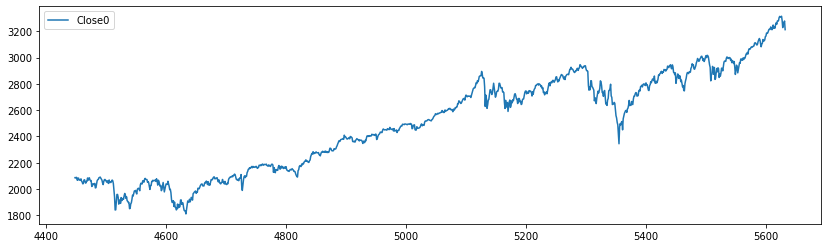

In [8]:
df.loc[4448:, ['Close0']].plot(figsize=(14,4))
df.shape

### 書き出す場合は以下を実行

In [9]:
# 書き出し
#df.to_csv(f'{base_dir}/e-mini-sp500-daily-last10days-base.csv')

# 学習用データ作成

過去10日間の全指標から、当日上昇するか否かを予測するための学習用データ

- `Date`, `Time`, `year`は不要
- 当日の指標については、`CODiff0`以外は不要
- `CODiff0`から当日上昇する場合は1そうでない場合は0となる二値データ列（`isUp`）を作成
    - その後`CODiff0`も不要
- 曜日列を数値に置き換える
    - MonからFriを0から4に置き換える
- TDMを数値に置き換える
    - Early, Mid, Late ==> 0, 1, 2

In [10]:
# Up0列追加
# 注意：1なら上昇、0なら横ばいか下降
dfp = df.copy()
#dfp['isUp'] = dfp['CODiff0'].map(lambda x: 1 if x > 0 else 0)
dfp['isUp'] = dfp['CODiff0'] > 0
dfp[['CODiff0', 'isUp']].head(6)

,CODiff0,isUp
0,7.75,True
1,5.50,True
2,6.00,True
3,0.75,True
4,9.25,True
5,-7.50,False


In [11]:
# MonからFriを0から4に置き換える
dfp['day'] = dfp['day'].cat.codes

In [12]:
# TDMの列を数値に置き換える
dfp['tdm'] = dfp['tdm'].mask(dfp['tdm'] == 'Early', 0)
dfp['tdm'] = dfp['tdm'].mask(dfp['tdm'] == 'Mid', 1)
dfp['tdm'] = dfp['tdm'].mask(dfp['tdm'] == 'Late', 2)

In [13]:
# ポジティブとネガティブで偏りがないか
dfp.groupby('isUp')['isUp'].count()

# あまりない

isUp
False    2613
True     3020
Name: isUp, dtype: int64

# データの分割

訓練データとテストデータに分割する。過去一定期間のデータから当日のデータを予測するという時系列データのためシャッフルして分割すると訓練データとテストデータの間で情報の重複が発生するから、シャッフルしない。また分割するところでも重複が発生するから重複分のデータを除外する（パージング）。

In [14]:
# 訓練データを何割にするか
train_ratio = 0.8

train_df, test_df = fl.split_data(dfp, train_ratio, purging=True, n_bars=N_BARS+1)

print(f'もとデータのサンプル数 = {df.shape[0]}')
print(f'訓練データのサンプル数 = {train_df.shape[0]}')
print(f'テストデータのサンプル数 = {test_df.shape[0]}')
print(f'いくつのサンプルがパージされたか：{df.shape[0] - train_df.shape[0] - test_df.shape[0]}')

もとデータのサンプル数 = 5633
訓練データのサンプル数 = 4498
テストデータのサンプル数 = 1125
いくつのサンプルがパージされたか：10


訓練データの期間：1997-10-01 - 2015-07-29
テストデータの期間：2015-08-13 - 2020-01-31


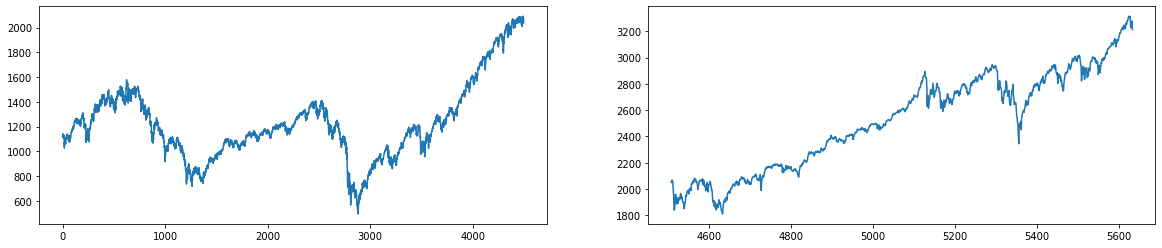

In [15]:
# 各データの期間
print(f"訓練データの期間：{train_df['Date'].iloc[0].strftime('%Y-%m-%d')} - {train_df['Date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"テストデータの期間：{test_df['Date'].iloc[0].strftime('%Y-%m-%d')} - {test_df['Date'].iloc[-1].strftime('%Y-%m-%d')}")
fix, ax = plt.subplots(1, 2, figsize=(20, 4))
train_df['Close0'].plot(ax=ax[0])
test_df['Close0'].plot(ax=ax[1])

In [16]:
# 不要な列を削除
drop_cols = ['Date','Time','year','Open0','High0','Low0','Close0','Vol0','OI0','CODiff0','HLDiff0',
             'HCDiff0','OLDiff0','CLDiff0','CSlope0','OSlope0','LSlope0','HSlope0','VSlope0','OISlope0','HCSlope0','CLSlope0']
train_data = train_df.drop(drop_cols, axis=1)
test_data = test_df.drop(drop_cols, axis=1)

# 入力と出力

In [17]:
x_train = train_data.drop(['isUp'], axis=1)
y_train = train_data['isUp']

x_test = test_data.drop(['isUp'], axis=1)
y_test = test_data['isUp']

In [18]:
# ウォークフォワード用のデータを作る関数
def purged_kfold_data_gen(xs, ys, k, n_dups=0, pct_embargo=0.):
    if xs.shape[0] != xs.shape[1]:
        raise ValueError('sample sizes of xs and xy must be the same.')
    
    data_size = xs.shape[0]

    def gen_split_points(data_size, k):
        block_size = data_size // k
        return [0] + list(range(block_size, data_size, block_size))[:k-1] + [data_size]

    idxs = gen_split_points(data_size, k)
    
    def train_test_split(df, test_idx, n_dups=0, pct_embargo=0.005):
        train_ratio = 1 - (test_idx[1] - test_idx[0]) / df.shape[0]

        train_f = df.iloc[:test_idx[0]]
        test = df.iloc[test_idx[0]:test_idx[1]]
        train_l = df.iloc[test_idx[1]:]

        # for the former train data block
        if n_dups > 0:
            if train_f.shape[0] <= n_dups:
                train_f = pd.DataFrame([])
            else:
                purge_idx_f = round(n_dups * train_ratio)
                train_f = train_f.iloc[:-purge_idx_f]
                test = test.iloc[(n_dups - purge_idx_f):]

        # for the latter train data block
        if pct_embargo > 0:
            n_dups = n_dups + round(df.shape[0] * 0.5)

            if train_l.shape[0] <= n_dups:
                train_l = pd.DataFrame([])
            else:
                purge_idx_l = round(n_dups * train_ratio)
                test = test.iloc[:-(n_dups - purge_idx_f)]
                train_l = train_l.iloc[purge_idx_f:]

        train = pd.concat([train_f, train_l])
        return train, test

    for i in range(k):
        x_train, x_test = train_test_split(xs, (idxs[i], idxs[i+1]), n_dups=n_dups, pct_embargo=pct_embargo)
        y_train, y_test = train_test_split(ys, (idxs[i], idxs[i+1]), n_dups=n_dups, pct_embargo=pct_embargo)
        yield (x_train, y_train), (x_test, y_test)

In [43]:
# sklearnのK分割交差検証用クラスを拡張してパージング有りエンバーゴ有りのK分割クラスを定義
from sklearn.model_selection._split import _BaseKFold
class PurgedKFold(_BaseKFold):
    def __init__(self, n_splits=5, n_dups=0, pct_embargo=0.):
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.n_dups = n_dups
        self.pct_embargo = pct_embargo

    def split(self, X, y=None, groups=None):
        train_ratio = (self.n_splits - 1) / self.n_splits
        indices = np.arange(X.shape[0])
        n_embargo = int(X.shape[0] * self.pct_embargo)
        test_starts = [(i[0], i[-1]+1) for i in np.array_split(indices, self.n_splits)]
        for i, j in test_starts:
            if self.n_dups > 0:
                train_f_purge = round(self.n_dups * train_ratio)
                train_f_idx1 = i - train_f_purge
                test_idx0 = i + (self.n_dups - train_f_purge)
            else:
                train_f_idx1 = test_idx0 = i

            if n_embargo > 0:
                purge_range = self.n_dups + n_embargo
                train_l_purge = round(purge_range * train_ratio)
                test_idx1 = j - (purge_range - train_l_purge)
                train_l_idx0 = j + train_l_purge
            else:
                test_idx1 = train_l_idx0 = j

            train_f_indices = pd.Series(X.iloc[0:train_f_idx1].index)
            test_indices = pd.Series(X.iloc[test_idx0:test_idx1].index)
            train_l_indices = pd.Series(X.iloc[train_l_idx0:].index)
            train_indices = pd.concat([train_f_indices, train_l_indices])
            yield train_indices, test_indices

# ロジスティック回帰


In [19]:
x_train.head(3)

,Open10,High10,Low10,Close10,Vol10,OI10,Open9,High9,Low9,Close9,...,OSlope9,LSlope9,HSlope9,VSlope9,OISlope9,HCSlope9,CLSlope9,month,day,tdm
0,1108.50,1115.00,1104.00,1108.5,10849,5516,1108.25,1123.00,1107.25,1110.5,...,-0.25,3.25,8.00,739.0,606.0,14.50,1.25,10,2,0
1,1108.25,1123.00,1107.25,1110.5,11588,6122,1112.50,1115.75,1105.50,1113.5,...,4.25,-1.75,-7.25,-1708.0,-286.0,5.25,5.00,10,3,0
2,1112.50,1115.75,1105.50,1113.5,9880,5836,1112.75,1124.50,1112.75,1118.5,...,0.25,7.25,8.75,2196.0,157.0,11.00,0.75,10,4,0


In [20]:
from sklearn.linear_model import LogisticRegression
lrm = LogisticRegression()
lrm.fit(x_train, y_train)

print("coefficient = ", lrm.coef_)
print("intercept = ", lrm.intercept_)

coefficient =  [[ 2.36757254e-10  2.35092890e-10  2.35080016e-10  2.47935836e-10
  -6.79108907e-08  8.65510497e-08  2.57418227e-10  2.47154958e-10
   2.17251870e-10  2.14581895e-10 -9.57959667e-09  9.15158174e-08
   2.08754457e-10  2.01790230e-10  2.54970525e-10  2.69059676e-10
   7.50656957e-09  3.37626752e-08  2.65344279e-10  2.39119957e-10
   2.68891695e-10  2.06773763e-10  1.01320430e-08  6.66567385e-08
   2.07849126e-10  2.15762771e-10  2.17781663e-10  1.87455326e-10
  -1.16656285e-08  1.88883092e-07  1.82480576e-10  1.29909069e-10
   1.78692653e-10  1.40572941e-10  3.44556327e-08 -1.59484601e-07
   1.34697346e-10  1.25042100e-10  1.33867199e-10  9.82099200e-11
   3.12483602e-08 -1.21887091e-08  9.74304094e-11  9.10658023e-11
   1.27091767e-10  1.19812714e-10 -4.02986299e-08 -7.50735115e-08
   1.40817885e-10  9.93010429e-11  1.19858838e-10  1.03699667e-10
  -1.21624042e-08  2.73563243e-08  1.02383381e-10  8.84850570e-11
   1.04691549e-10  3.13462013e-11  6.07377371e-08 -1.66041983

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# テスト
y_pred_lr = lrm.predict(x_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_lr))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred_lr))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred_lr))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred_lr))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred_lr))
print(classification_report(y_test, y_pred_lr))

confusion matrix = 
 [[ 63 438]
 [ 57 567]]
accuracy =  0.56
precision =  0.564179104477612
recall =  0.9086538461538461
f1 score =  0.696132596685083
              precision    recall  f1-score   support

       False       0.53      0.13      0.20       501
        True       0.56      0.91      0.70       624

    accuracy                           0.56      1125
   macro avg       0.54      0.52      0.45      1125
weighted avg       0.55      0.56      0.48      1125



# ランダムフォレスト

In [22]:
from sklearn.ensemble import RandomForestClassifier
rfm = RandomForestClassifier()
rfm.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
# テスト
y_pred_rf = rfm.predict(x_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_rf))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred_rf))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred_rf))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred_rf))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred_rf))
print(classification_report(y_test, y_pred_lr))

confusion matrix = 
 [[241 260]
 [302 322]]
accuracy =  0.5004444444444445
precision =  0.5532646048109966
recall =  0.5160256410256411
f1 score =  0.5339966832504146
              precision    recall  f1-score   support

       False       0.53      0.13      0.20       501
        True       0.56      0.91      0.70       624

    accuracy                           0.56      1125
   macro avg       0.54      0.52      0.45      1125
weighted avg       0.55      0.56      0.48      1125



# ランダムフォレストでグリッドサーチ

In [34]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators': [10],
    'max_depth': [40],
    'min_samples_split': [20],
    'min_samples_leaf': [50],
}
#    'min_samples_split': [4, 8, 16],
#    'min_samples_leaf': [4, 8, 16]
pkf = fl.PurgedKFold(n_splits=5, n_overlaps=10, pct_embargo=0.05)
rfcv = GridSearchCV(rfm, params, cv=pkf, n_jobs=-1)
rfcv.fit(x_train, y_train)

GridSearchCV(cv=PurgedKFold(n_overlaps=10, n_splits=5, pct_embargo=0.05),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              

In [35]:
from sklearn.metrics import accuracy_score
rf_best = rfcv.best_estimator_
print('best parameters:', rfcv.best_params_)

y_pred_tr = rf_best.predict(x_train)
print(f'training accuracy: {accuracy_score(y_train, y_pred_tr)}')

y_pred_te = rf_best.predict(x_test)
print(f'training accuracy: {accuracy_score(y_test, y_pred_te)}')

best parameters: {'max_depth': 40, 'min_samples_leaf': 50, 'min_samples_split': 20, 'n_estimators': 10}
training accuracy: 0.6729657625611383
training accuracy: 0.504
